In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tf as tf

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

In [5]:
TARGET = 'stft_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4']

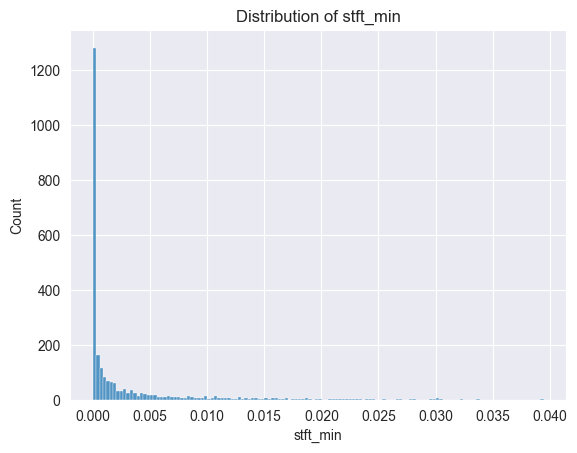

In [6]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg[TARGET] == 0]
df_nz = df_reg[df_reg[TARGET] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=100)

y_train = np.log10(df_train[TARGET].to_numpy())
y_valid = np.log10(df_valid[TARGET].to_numpy())
y_test = np.log10(df_test[TARGET].to_numpy())

df_zero = df_zero.drop([TARGET], axis=1)
df_train = df_train.drop([TARGET], axis=1)
df_valid = df_valid.drop([TARGET], axis=1)
df_test = df_test.drop([TARGET], axis=1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(847, 270) (212, 270) (361, 270) (1009, 270)


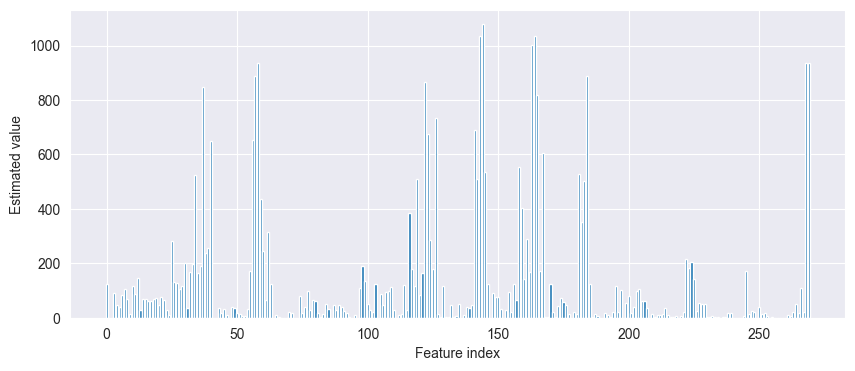

In [8]:
f_selector = SelectKBest(score_func=f_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated value')
plt.show()

In [9]:
f_selector = SelectKBest(score_func=f_regression, k=20)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_train.iloc[:, selected_indices]

,mfcc_q25,mfcc_q99,stft_mean,stft_std,stft_q25,mfcc_q25_w2,mfcc_q50_w2,mfcc_q99_w2,stft_sum_w2,stft_q05_w2,stft_q25_w2,stft_skew_w2,mfcc_sum_w3,mfcc_q25_w3,mfcc_q50_w3,mfcc_q75_w3,mfcc_q99_w3,stft_q25_w3,sex_F,sex_M
259,-18.582673,133.537021,0.391166,0.350493,0.037039,-25.548968,-14.335812,131.763970,316.827272,0.002076,0.019907,1.368237,-70611.711781,-25.377122,-12.167407,-1.477520,141.949765,0.006469,1,0
157,-2.432008,140.389436,0.618064,0.281252,0.400627,-11.883626,0.331137,157.141432,487.714941,0.047736,0.247174,-0.016021,-37384.776127,-9.452207,0.308263,9.277478,208.015807,0.228734,0,1
667,-10.434671,169.611666,0.499650,0.347630,0.142961,-18.150980,-7.070016,177.324767,409.154710,0.007334,0.053486,0.865939,-39253.197492,-17.626914,-5.782738,6.776643,182.314767,0.089444,0,1
707,-11.989990,140.775630,0.500564,0.321720,0.203172,-19.689170,-6.076445,132.367535,424.497157,0.012076,0.085660,0.328339,-46073.398204,-21.128508,-10.204088,2.029520,174.004688,0.052809,1,0
125,-6.579166,90.324497,0.475922,0.349201,0.106374,-15.118881,0.000000,92.440168,351.456816,0.002707,0.027473,0.804747,-39812.423944,-25.070787,-7.274005,9.855553,124.347880,0.013650,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,-10.531611,188.840487,0.448354,0.342674,0.105303,-16.788827,-4.730709,181.582949,469.988087,0.016418,0.071749,0.886020,-54877.142055,-18.882193,-4.978764,7.866954,207.137736,0.043049,0,1
53,-10.841864,159.482310,0.512951,0.316919,0.221845,-20.016054,-4.384253,176.553050,452.237700,0.045298,0.156050,0.706239,-30872.660059,-18.504748,-4.311820,10.084295,166.648179,0.122665,0,1
350,-7.651122,151.113206,0.543641,0.328328,0.233966,-13.594585,-2.200245,156.181359,492.584031,0.025636,0.164514,0.347103,-38947.164248,-17.357152,-6.596020,6.551662,192.158127,0.081348,1,0
79,-10.683922,143.316089,0.513574,0.286984,0.275286,-11.417866,-2.853683,147.437486,577.809521,0.057310,0.276032,0.175891,-37772.767541,-16.525048,-5.833418,5.294950,171.602208,0.172040,0,1


In [10]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

## XGBoost

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=1, n_jobs=-1)

[I 2023-06-06 18:34:52,703] A new study created in memory with name: no-name-7d9a19ad-9e9c-4ad8-92de-8335eb5b9b51
[I 2023-06-06 18:34:53,010] Trial 0 finished with value: 0.11062560721036152 and parameters: {'booster': 'dart', 'gamma': 3.703844713417619, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.49664111945153055}. Best is trial 0 with value: 0.11062560721036152.


In [12]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 3.703844713417619, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.49664111945153055}
Root mean squared error = 0.3840
R-squared = 0.6778


In [13]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([0.01006559, 0.01006559, 0.00795419, ..., 0.00016802, 0.00013427,
       0.00013427], dtype=float32)

In [14]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [15]:
df_zero[TARGET] = y_pred
df.update(df_zero)

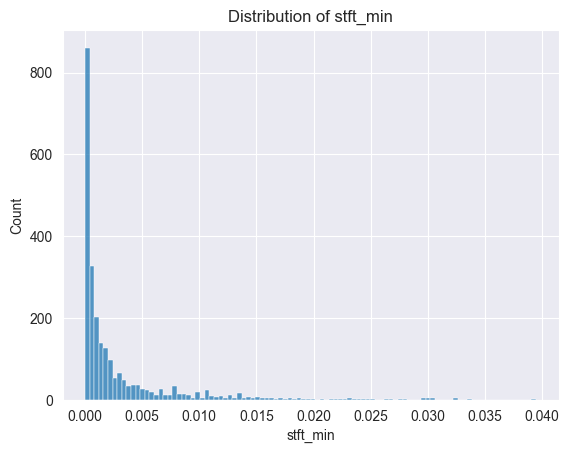

In [16]:
sns.histplot(data=df, x=TARGET)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

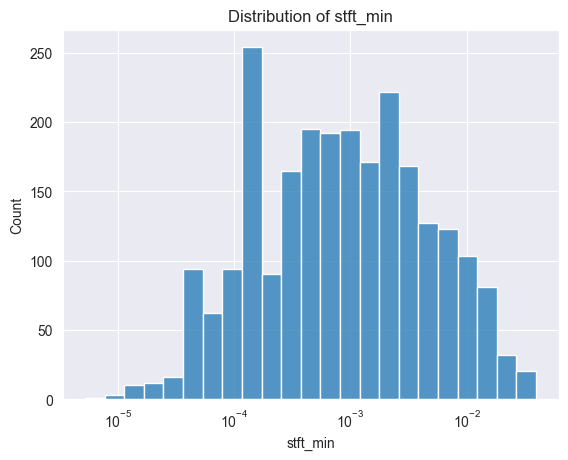

In [17]:
sns.histplot(data=df, x=TARGET, log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

## Neural Network

In [18]:
import tensorflow
from keras import Sequential
from keras.layers import Dense

def create_model(trial):

    n_hidden = trial.suggest_int('n_hidden', 1, 3)
    n_units = trial.suggest_int('n_units', 32, 128)
    learn_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)

    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train.shape[1], activation='relu'))

    for i in range(n_hidden):
        model.add(Dense(n_units, activation='relu'))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learn_rate),
                  metrics=tensorflow.keras.metrics.MeanSquaredError())
    return model


# objective function to be minimized
def objective_fun(trial):

    model = create_model(trial)
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid), verbose=False)

    y_pred = model.predict(X_valid)
    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=100, n_jobs=-1)

[I 2023-06-06 18:34:56,743] A new study created in memory with name: no-name-082e73ba-ce31-465f-8687-7a4f869cf1be


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:34:59,288] Trial 7 finished with value: 0.16050885109453394 and parameters: {'n_hidden': 1, 'n_units': 49, 'learning_rate': 0.06784879239092631}. Best is trial 7 with value: 0.16050885109453394.


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:34:59,318] Trial 6 finished with value: 0.15821098462041855 and parameters: {'n_hidden': 1, 'n_units': 122, 'learning_rate': 0.0153557452296386}. Best is trial 6 with value: 0.15821098462041855.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-06 18:34:59,362] Trial 3 finished with value: 0.1609158237630155 and parameters: {'n_hidden': 2, 'n_units': 40, 'learning_rate': 0.0901492527326611}. Best is trial 6 with value: 0.15821098462041855.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-06 18:34:59,435] Trial 4 finished with value: 0.1895827836327629 and parameters: {'n_hidden': 3, 'n_units': 128, 'learning_rate': 0.08492206916603057}. Best is trial 6 with value: 0.15821098462041855.


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:34:59,452] Trial 2 finished with value: 0.14703826107099102 and parameters: {'n_hidden': 1, 'n_units': 35, 'learning_rate': 0.011798972860688423}. Best is trial 2 with value: 0.14703826107099102.


7/7 [==============================] - 0s 8ms/step


7/7 [==============================] - 0s 8ms/step


[I 2023-06-06 18:34:59,543] Trial 5 finished with value: 0.19046161376208848 and parameters: {'n_hidden': 3, 'n_units': 95, 'learning_rate': 0.026094479772101567}. Best is trial 2 with value: 0.14703826107099102.
[I 2023-06-06 18:34:59,557] Trial 0 finished with value: 0.14986720621274952 and parameters: {'n_hidden': 3, 'n_units': 126, 'learning_rate': 0.01761650459366454}. Best is trial 2 with value: 0.14703826107099102.
[I 2023-06-06 18:34:59,583] Trial 1 finished with value: 0.17047726668769464 and parameters: {'n_hidden': 1, 'n_units': 53, 'learning_rate': 0.06227228418484587}. Best is trial 2 with value: 0.14703826107099102.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:01,906] Trial 8 finished with value: 0.1977125477859595 and parameters: {'n_hidden': 2, 'n_units': 85, 'learning_rate': 0.05004549846679425}. Best is trial 2 with value: 0.14703826107099102.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-06 18:35:02,012] Trial 12 finished with value: 0.1467013127062448 and parameters: {'n_hidden': 2, 'n_units': 35, 'learning_rate': 0.030908537956130622}. Best is trial 12 with value: 0.1467013127062448.


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:35:02,114] Trial 11 finished with value: 0.18363263602812724 and parameters: {'n_hidden': 2, 'n_units': 127, 'learning_rate': 0.04872141813425359}. Best is trial 12 with value: 0.1467013127062448.


7/7 [==============================] - 0s 4ms/step


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:35:02,198] Trial 10 finished with value: 0.18666981666578128 and parameters: {'n_hidden': 3, 'n_units': 54, 'learning_rate': 0.016817329432873816}. Best is trial 12 with value: 0.1467013127062448.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:02,296] Trial 15 finished with value: 0.14838061241289044 and parameters: {'n_hidden': 3, 'n_units': 49, 'learning_rate': 0.01788386817312971}. Best is trial 12 with value: 0.1467013127062448.


7/7 [==============================] - ETA: 0s

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 13ms/step


[I 2023-06-06 18:35:02,647] Trial 14 finished with value: 0.2276928124448776 and parameters: {'n_hidden': 2, 'n_units': 102, 'learning_rate': 0.09204905895105228}. Best is trial 12 with value: 0.1467013127062448.


7/7 [==============================] - 0s 24ms/step


[I 2023-06-06 18:35:02,721] Trial 13 finished with value: 0.13232557886534113 and parameters: {'n_hidden': 3, 'n_units': 107, 'learning_rate': 0.03086232790788675}. Best is trial 13 with value: 0.13232557886534113.
[I 2023-06-06 18:35:02,774] Trial 9 finished with value: 0.21109850030458338 and parameters: {'n_hidden': 2, 'n_units': 127, 'learning_rate': 0.05369001764298745}. Best is trial 13 with value: 0.13232557886534113.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:04,524] Trial 16 finished with value: 0.16766236424111375 and parameters: {'n_hidden': 1, 'n_units': 93, 'learning_rate': 0.08737683374683997}. Best is trial 13 with value: 0.13232557886534113.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-06 18:35:04,699] Trial 19 finished with value: 0.15573087189913304 and parameters: {'n_hidden': 1, 'n_units': 32, 'learning_rate': 0.006949572615045051}. Best is trial 13 with value: 0.13232557886534113.
[I 2023-06-06 18:35:04,703] Trial 18 finished with value: 0.1967032752662156 and parameters: {'n_hidden': 1, 'n_units': 34, 'learning_rate': 0.0005229167709979166}. Best is trial 13 with value: 0.13232557886534113.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:04,863] Trial 17 finished with value: 0.11211784893340758 and parameters: {'n_hidden': 2, 'n_units': 67, 'learning_rate': 0.032975421691815}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:04,893] Trial 20 finished with value: 0.14668757004558622 and parameters: {'n_hidden': 1, 'n_units': 32, 'learning_rate': 0.006559230108338235}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 16ms/step


[I 2023-06-06 18:35:05,095] Trial 21 finished with value: 0.18762979108887523 and parameters: {'n_hidden': 1, 'n_units': 32, 'learning_rate': 0.0016740942806373928}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

1/7 [===>..........................] - ETA: 1s

[I 2023-06-06 18:35:05,569] Trial 22 finished with value: 0.11819825767656726 and parameters: {'n_hidden': 2, 'n_units': 65, 'learning_rate': 0.031167573267385236}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:05,699] Trial 23 finished with value: 0.2000754542908009 and parameters: {'n_hidden': 2, 'n_units': 68, 'learning_rate': 0.03537559526150647}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:07,452] Trial 24 finished with value: 0.13888781374350115 and parameters: {'n_hidden': 2, 'n_units': 64, 'learning_rate': 0.033942468221902784}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 12ms/step


[I 2023-06-06 18:35:07,835] Trial 29 finished with value: 0.1484050514218046 and parameters: {'n_hidden': 2, 'n_units': 69, 'learning_rate': 0.033971987927065295}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:07,867] Trial 26 finished with value: 0.1646878621898033 and parameters: {'n_hidden': 2, 'n_units': 70, 'learning_rate': 0.032901769127046815}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:07,876] Trial 28 finished with value: 0.12853378934318824 and parameters: {'n_hidden': 2, 'n_units': 68, 'learning_rate': 0.0346033394147815}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:07,893] Trial 30 finished with value: 0.1383403333068532 and parameters: {'n_hidden': 2, 'n_units': 70, 'learning_rate': 0.03531610007114392}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:07,936] Trial 27 finished with value: 0.1325102720036865 and parameters: {'n_hidden': 2, 'n_units': 68, 'learning_rate': 0.03594105091861508}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:08,154] Trial 31 finished with value: 0.18272919322253373 and parameters: {'n_hidden': 2, 'n_units': 69, 'learning_rate': 0.03842260084175882}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-06 18:35:08,873] Trial 25 finished with value: 0.12789067339529808 and parameters: {'n_hidden': 2, 'n_units': 68, 'learning_rate': 0.03034445120273249}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:10,197] Trial 32 finished with value: 0.1438449377065016 and parameters: {'n_hidden': 2, 'n_units': 74, 'learning_rate': 0.04156803996327599}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:10,552] Trial 35 finished with value: 0.11708670303651869 and parameters: {'n_hidden': 2, 'n_units': 78, 'learning_rate': 0.04175777156135048}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:10,556] Trial 34 finished with value: 0.12501528818595156 and parameters: {'n_hidden': 2, 'n_units': 78, 'learning_rate': 0.04156093163558196}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-06 18:35:10,727] Trial 37 finished with value: 0.1419186525159503 and parameters: {'n_hidden': 2, 'n_units': 79, 'learning_rate': 0.023458933769559417}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 8ms/step


[I 2023-06-06 18:35:10,861] Trial 33 finished with value: 0.15993205813063743 and parameters: {'n_hidden': 3, 'n_units': 114, 'learning_rate': 0.041645176226239894}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:35:11,291] Trial 38 finished with value: 0.13116891789655952 and parameters: {'n_hidden': 3, 'n_units': 79, 'learning_rate': 0.026942762729811418}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 12ms/step


[I 2023-06-06 18:35:11,436] Trial 36 finished with value: 0.1533448685997027 and parameters: {'n_hidden': 2, 'n_units': 79, 'learning_rate': 0.02313993538813907}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 19ms/step


[I 2023-06-06 18:35:11,772] Trial 39 finished with value: 0.12939885869017465 and parameters: {'n_hidden': 2, 'n_units': 78, 'learning_rate': 0.024169143276410076}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:13,095] Trial 40 finished with value: 0.17521039628638646 and parameters: {'n_hidden': 2, 'n_units': 58, 'learning_rate': 0.02344144195211369}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-06 18:35:13,364] Trial 42 finished with value: 0.13440806408503936 and parameters: {'n_hidden': 2, 'n_units': 80, 'learning_rate': 0.04452740545835965}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:13,396] Trial 41 finished with value: 0.16170249476283818 and parameters: {'n_hidden': 2, 'n_units': 81, 'learning_rate': 0.024017354448991873}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-06 18:35:13,518] Trial 43 finished with value: 0.11585547664651602 and parameters: {'n_hidden': 3, 'n_units': 58, 'learning_rate': 0.042281753991978054}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 6ms/step


[I 2023-06-06 18:35:13,692] Trial 44 finished with value: 0.1835416879307717 and parameters: {'n_hidden': 2, 'n_units': 81, 'learning_rate': 0.02254014136455732}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 13ms/step


[I 2023-06-06 18:35:13,866] Trial 45 finished with value: 0.15103847639329804 and parameters: {'n_hidden': 2, 'n_units': 58, 'learning_rate': 0.022656485345965642}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 10ms/step


[I 2023-06-06 18:35:14,036] Trial 46 finished with value: 0.13615880775324316 and parameters: {'n_hidden': 2, 'n_units': 87, 'learning_rate': 0.04561868120218781}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-06 18:35:14,423] Trial 47 finished with value: 0.1283726608878033 and parameters: {'n_hidden': 2, 'n_units': 58, 'learning_rate': 0.043927467392550705}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:16,100] Trial 48 finished with value: 0.12232460636499892 and parameters: {'n_hidden': 2, 'n_units': 88, 'learning_rate': 0.04244748519300145}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:35:16,287] Trial 50 finished with value: 0.12677442658629245 and parameters: {'n_hidden': 2, 'n_units': 61, 'learning_rate': 0.055706300089418945}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-06 18:35:16,363] Trial 49 finished with value: 0.16194608368814145 and parameters: {'n_hidden': 2, 'n_units': 61, 'learning_rate': 0.04520059902395726}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:16,796] Trial 51 finished with value: 0.3968948898934489 and parameters: {'n_hidden': 3, 'n_units': 88, 'learning_rate': 0.053214481343783114}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:16,804] Trial 52 finished with value: 0.33396269489780583 and parameters: {'n_hidden': 3, 'n_units': 61, 'learning_rate': 0.05718058627426704}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:16,842] Trial 54 finished with value: 0.14089683747288723 and parameters: {'n_hidden': 3, 'n_units': 47, 'learning_rate': 0.054639404461860136}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-06 18:35:17,046] Trial 53 finished with value: 0.2756050962422651 and parameters: {'n_hidden': 3, 'n_units': 89, 'learning_rate': 0.057166308825632714}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-06 18:35:18,089] Trial 55 finished with value: 0.5972730583156407 and parameters: {'n_hidden': 3, 'n_units': 45, 'learning_rate': 0.05620296860335383}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:19,164] Trial 56 finished with value: 0.2119784874209605 and parameters: {'n_hidden': 3, 'n_units': 91, 'learning_rate': 0.05495407258211489}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 10ms/step


[I 2023-06-06 18:35:19,380] Trial 58 finished with value: 0.14626837344172797 and parameters: {'n_hidden': 3, 'n_units': 88, 'learning_rate': 0.038846404062036384}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-06 18:35:19,459] Trial 57 finished with value: 0.131684641390005 and parameters: {'n_hidden': 3, 'n_units': 51, 'learning_rate': 0.04863594632277626}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 11ms/step


[I 2023-06-06 18:35:19,833] Trial 60 finished with value: 0.12936825468947477 and parameters: {'n_hidden': 2, 'n_units': 92, 'learning_rate': 0.039432315489334374}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:35:20,054] Trial 59 finished with value: 0.12762316761931916 and parameters: {'n_hidden': 2, 'n_units': 46, 'learning_rate': 0.03963265763232868}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 11ms/step


7/7 [==============================] - 0s 14ms/step


[I 2023-06-06 18:35:20,210] Trial 61 finished with value: 0.1372114191429346 and parameters: {'n_hidden': 2, 'n_units': 96, 'learning_rate': 0.03964281066965965}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:20,263] Trial 62 finished with value: 0.163262838958142 and parameters: {'n_hidden': 2, 'n_units': 98, 'learning_rate': 0.05080480392343953}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-06 18:35:21,350] Trial 63 finished with value: 0.14977338198739767 and parameters: {'n_hidden': 2, 'n_units': 96, 'learning_rate': 0.040314887451481006}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:35:22,421] Trial 65 finished with value: 0.11738314984984234 and parameters: {'n_hidden': 2, 'n_units': 97, 'learning_rate': 0.04770814265100533}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:22,449] Trial 64 finished with value: 0.1312682932431147 and parameters: {'n_hidden': 2, 'n_units': 98, 'learning_rate': 0.03983020835306224}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 6ms/step


[I 2023-06-06 18:35:22,676] Trial 67 finished with value: 0.1419739626990277 and parameters: {'n_hidden': 2, 'n_units': 75, 'learning_rate': 0.02979174036937868}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

[I 2023-06-06 18:35:23,122] Trial 68 finished with value: 0.16014454103333586 and parameters: {'n_hidden': 2, 'n_units': 99, 'learning_rate': 0.048384360777055324}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-06 18:35:23,170] Trial 66 finished with value: 0.13398520537789374 and parameters: {'n_hidden': 2, 'n_units': 98, 'learning_rate': 0.039563678332826556}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-06 18:35:23,360] Trial 69 finished with value: 0.16031878997158025 and parameters: {'n_hidden': 2, 'n_units': 74, 'learning_rate': 0.04983077763086277}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:23,420] Trial 70 finished with value: 0.16011550953200418 and parameters: {'n_hidden': 2, 'n_units': 73, 'learning_rate': 0.028915165654156704}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:24,311] Trial 71 finished with value: 0.13787269900079085 and parameters: {'n_hidden': 2, 'n_units': 84, 'learning_rate': 0.02972191704224797}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:25,288] Trial 72 finished with value: 0.14408442100103247 and parameters: {'n_hidden': 2, 'n_units': 107, 'learning_rate': 0.030075450019583855}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:25,325] Trial 73 finished with value: 0.16560215056717675 and parameters: {'n_hidden': 2, 'n_units': 73, 'learning_rate': 0.03049603613480969}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:25,550] Trial 74 finished with value: 0.15235007854243485 and parameters: {'n_hidden': 2, 'n_units': 84, 'learning_rate': 0.03635777148136857}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-06 18:35:25,702] Trial 75 finished with value: 0.20763877916744405 and parameters: {'n_hidden': 1, 'n_units': 84, 'learning_rate': 0.04331158101891629}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:25,741] Trial 76 finished with value: 0.1470336135269963 and parameters: {'n_hidden': 1, 'n_units': 73, 'learning_rate': 0.03663186184698913}. Best is trial 17 with value: 0.11211784893340758.


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 5ms/step


[I 2023-06-06 18:35:26,258] Trial 78 finished with value: 0.14264383217695867 and parameters: {'n_hidden': 2, 'n_units': 64, 'learning_rate': 0.036440812281806366}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:26,272] Trial 77 finished with value: 0.18274408383881782 and parameters: {'n_hidden': 1, 'n_units': 64, 'learning_rate': 0.036804882898224554}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:27,422] Trial 79 finished with value: 0.14369970858462167 and parameters: {'n_hidden': 2, 'n_units': 64, 'learning_rate': 0.03691071075812469}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:28,196] Trial 80 finished with value: 0.1307943303308966 and parameters: {'n_hidden': 2, 'n_units': 64, 'learning_rate': 0.0368890892005769}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-06 18:35:28,437] Trial 82 finished with value: 0.11321655164284578 and parameters: {'n_hidden': 1, 'n_units': 65, 'learning_rate': 0.04321989605538901}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-06 18:35:28,549] Trial 83 finished with value: 0.17791464817513675 and parameters: {'n_hidden': 2, 'n_units': 65, 'learning_rate': 0.04585567678252972}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 8ms/step


1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 4ms/step


[I 2023-06-06 18:35:28,771] Trial 84 finished with value: 0.12318262416671144 and parameters: {'n_hidden': 2, 'n_units': 64, 'learning_rate': 0.046208143821886295}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:28,815] Trial 81 finished with value: 0.157855646690729 and parameters: {'n_hidden': 2, 'n_units': 64, 'learning_rate': 0.036519840976495695}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 11ms/step


[I 2023-06-06 18:35:28,948] Trial 85 finished with value: 0.14846214412777842 and parameters: {'n_hidden': 2, 'n_units': 55, 'learning_rate': 0.0471458715809082}. Best is trial 17 with value: 0.11211784893340758.


6/7 [========================>.....] - ETA: 0s

7/7 [==============================] - 0s 13ms/step


[I 2023-06-06 18:35:29,136] Trial 86 finished with value: 0.1812213445958111 and parameters: {'n_hidden': 2, 'n_units': 54, 'learning_rate': 0.046477078268829505}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:30,196] Trial 87 finished with value: 0.13170185896946615 and parameters: {'n_hidden': 2, 'n_units': 54, 'learning_rate': 0.04727911689994697}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:31,087] Trial 88 finished with value: 0.14028187698554623 and parameters: {'n_hidden': 2, 'n_units': 39, 'learning_rate': 0.046571504212182833}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-06 18:35:31,463] Trial 89 finished with value: 0.14609188606839216 and parameters: {'n_hidden': 1, 'n_units': 104, 'learning_rate': 0.042434552817777416}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-06 18:35:31,646] Trial 91 finished with value: 0.11445656339666999 and parameters: {'n_hidden': 1, 'n_units': 54, 'learning_rate': 0.042469646572263216}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:31,772] Trial 93 finished with value: 0.11523140993789258 and parameters: {'n_hidden': 1, 'n_units': 55, 'learning_rate': 0.04206868546468064}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:31,786] Trial 92 finished with value: 0.17433407469291642 and parameters: {'n_hidden': 2, 'n_units': 54, 'learning_rate': 0.042952121926004}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-06 18:35:31,963] Trial 90 finished with value: 0.16860211715723072 and parameters: {'n_hidden': 1, 'n_units': 55, 'learning_rate': 0.04623681352918767}. Best is trial 17 with value: 0.11211784893340758.
[I 2023-06-06 18:35:32,006] Trial 94 finished with value: 0.157536650419323 and parameters: {'n_hidden': 1, 'n_units': 77, 'learning_rate': 0.04215659447891695}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 1ms/step


[I 2023-06-06 18:35:32,480] Trial 95 finished with value: 0.1603140683645305 and parameters: {'n_hidden': 1, 'n_units': 76, 'learning_rate': 0.042617914510735835}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 1ms/step


[I 2023-06-06 18:35:32,731] Trial 96 finished with value: 0.15382483114692633 and parameters: {'n_hidden': 1, 'n_units': 60, 'learning_rate': 0.04251014617434541}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 1ms/step


[I 2023-06-06 18:35:32,843] Trial 97 finished with value: 0.1439824060165147 and parameters: {'n_hidden': 1, 'n_units': 67, 'learning_rate': 0.032336055892056036}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 2ms/step


[I 2023-06-06 18:35:32,883] Trial 98 finished with value: 0.1566649174955182 and parameters: {'n_hidden': 1, 'n_units': 76, 'learning_rate': 0.04336708228453849}. Best is trial 17 with value: 0.11211784893340758.


7/7 [==============================] - 0s 557us/step


[I 2023-06-06 18:35:32,909] Trial 99 finished with value: 0.12972665314295692 and parameters: {'n_hidden': 1, 'n_units': 57, 'learning_rate': 0.03389688474809812}. Best is trial 17 with value: 0.11211784893340758.


In [19]:
model = create_model(study.best_trial)

y_pred_test = model.predict(X_test)

print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

12/12 [==============================] - 0s 581us/step
Root mean squared error = 2.7518
R-squared = -15.5430


In [20]:
y_pred = model.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

32/32 [==============================] - 0s 433us/step


array([[0.44786194],
       [0.45082343],
       [0.44174415],
       ...,
       [0.6130293 ],
       [0.59593785],
       [0.6281475 ]], dtype=float32)